In [17]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import sys
# add root folder to path
sys.path.append('../../')
from training.data.datasets import load_json_data
from tqdm import tqdm
import seaborn as sns

# Data Loading
## Raw Data (used for annotation)

In [18]:
with open("results/data_used_for_annotation_with_chatgpt.jsonl") as f:
    raw_data = [json.loads(line) for line in f]
raw_data = pd.DataFrame(raw_data)
print(raw_data.shape)
raw_data.head()

(1974, 6)


,id,title,text,category,climate_scanner,old_id
0,0,The Shattering Truth of 3D-Printed Clothing,When the fashion trio threeASFOUR debuted its ...,3d_printed_apparel,True,0
1,1,Soon you may be able to 3D print clothing in y...,Three-dimensional printing has changed the way...,3d_printed_apparel,True,1
2,2,A clothing startup founded by MIT grads is usi...,The Insider Picks team writes about stuff we t...,3d_printed_apparel,True,4
3,3,3D Printing of Clothing,3D Printing of Clothing\nThe technology behind...,3d_printed_apparel,True,5
4,4,3D printed fashion: Why is additive manufactur...,3D printed fashion: Why is additive manufactur...,3d_printed_apparel,True,6


## Predictions / Annotations

In [19]:
# load predictions.jsonl from current folder
with open("results/predictions.jsonl") as f:
    preds = [json.loads(line) for line in f]
preds = {list(p.keys())[0]:p[list(p.keys())[0]] for p in preds}
new_rows = []
for article_id, section_predictions in preds.items():
    for section_pred in section_predictions:
        new_row = {
            "article_id": article_id,
            "article_id (old)": raw_data.iloc[int(article_id)]["old_id"],
            "section_id": section_pred["section_id"],
            "section_category": section_pred["category"],
            "article_level_category": raw_data.iloc[int(article_id)]["category"],
            "text": section_pred["text"],
            "reasoning": section_pred["reasoning"],
            "explanation": section_pred["explanation"],
        }
        new_rows.append(new_row)
predictions = pd.DataFrame(new_rows)
predictions.shape

(44272, 8)

# Analysis of results
## Label Distribution

In [20]:
# count samples per label
predictions.section_category.value_counts()

section_category
sustainable_agriculture_production    3602
none                                  3443
smart_collaboration_tools             1497
unsure                                1401
carbon_price                          1340
                                      ... 
sustainable_energy                       3
electric_vehicles                        2
sustainable_energy_production            2
autonomous transport                     1
virtual_reality_travel_experiences       1
Name: count, Length: 78, dtype: int64

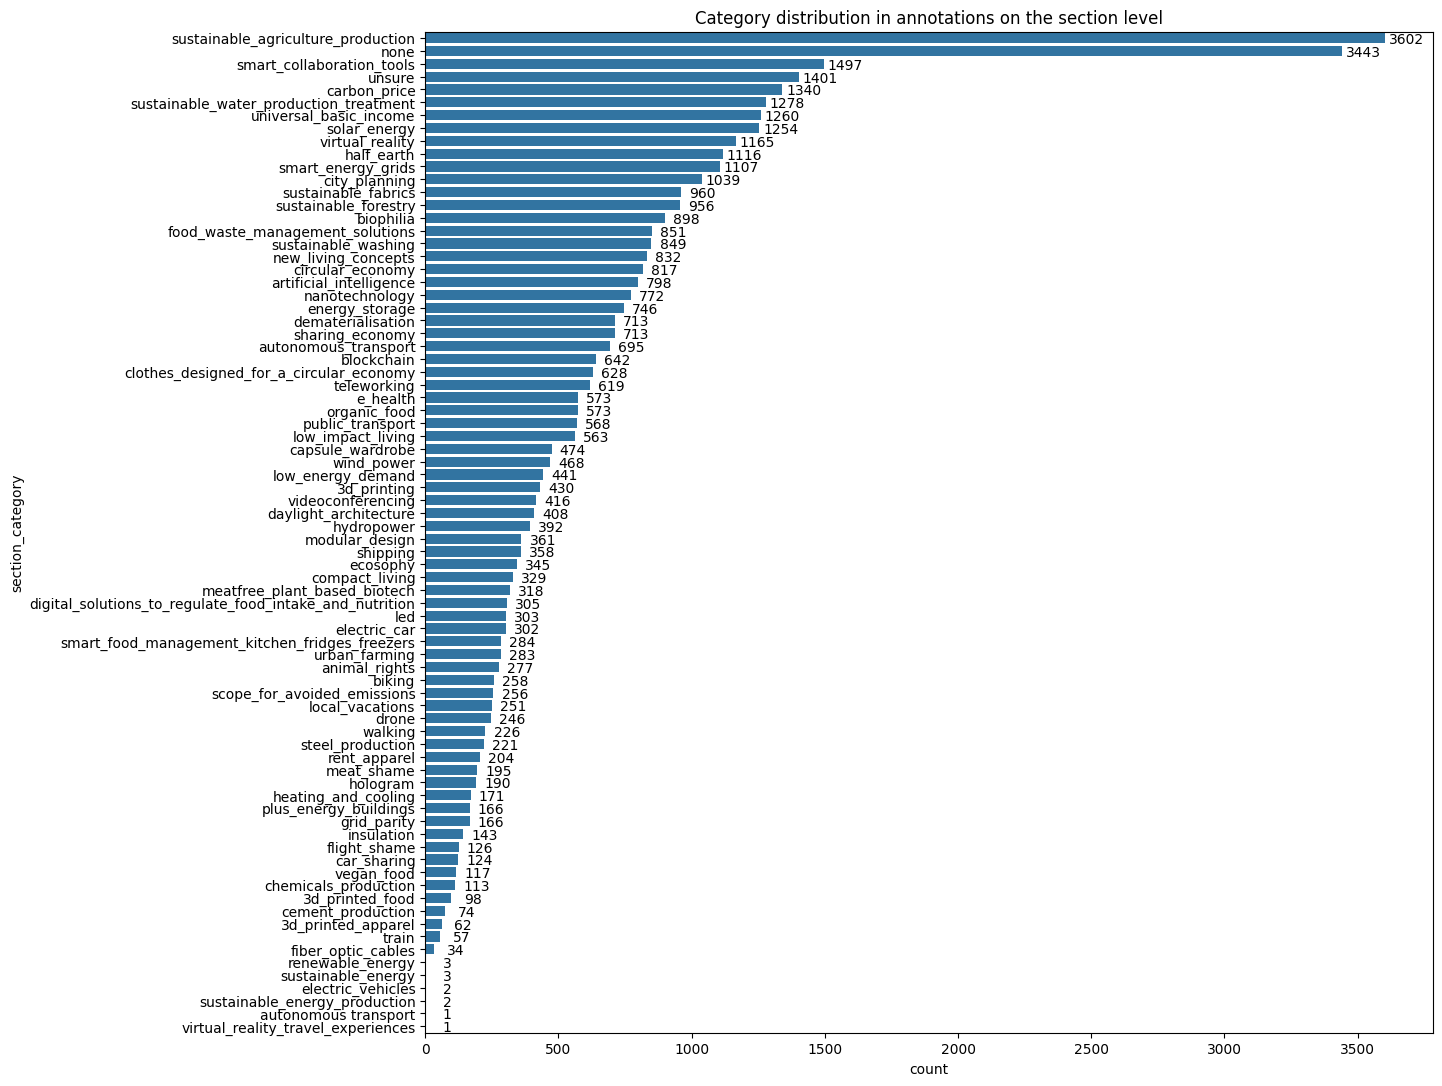

In [21]:
plt.figure(figsize=(13, 13))
ax = sns.countplot(y="section_category", data=predictions, order=predictions.section_category.value_counts().index)
plt.title("Category distribution in annotations on the section level")

# Add numbers to the bars
for p in ax.patches:
    width = p.get_width()
    plt.annotate(f'{int(width)}', (width + 80, p.get_y() + 0.5), ha='center', va='center')
plt.show()


## Check for categories that don't exist


In [22]:
true_categories = raw_data.category.unique()
predicted_categories = predictions.section_category.unique()
fictional_categories = [cat for cat in predicted_categories if cat not in true_categories]
print(sorted(true_categories))
print("Number of predictions with fictional categories: ", len(fictional_categories))
set(fictional_categories)

['3d_printed_apparel', '3d_printed_food', '3d_printing', 'animal_rights', 'artificial_intelligence', 'autonomous_transport', 'biking', 'biophilia', 'blockchain', 'capsule_wardrobe', 'car_sharing', 'carbon_price', 'cement_production', 'chemicals_production', 'circular_economy', 'city_planning', 'clothes_designed_for_a_circular_economy', 'compact_living', 'daylight_architecture', 'dematerialisation', 'digital_solutions_to_regulate_food_intake_and_nutrition', 'drone', 'e_health', 'ecosophy', 'electric_car', 'energy_storage', 'fiber_optic_cables', 'flight_shame', 'food_waste_management_solutions', 'grid_parity', 'half_earth', 'heating_and_cooling', 'hologram', 'hydropower', 'insulation', 'led', 'local_vacations', 'low_energy_demand', 'low_impact_living', 'meat_shame', 'meatfree_plant_based_biotech', 'modular_design', 'nanotechnology', 'new_living_concepts', 'organic_food', 'plus_energy_buildings', 'public_transport', 'rent_apparel', 'scope_for_avoided_emissions', 'sharing_economy', 'shippi

{'autonomous transport',
 'electric_vehicles',
 'none',
 'renewable_energy',
 'sustainable_energy',
 'sustainable_energy_production',
 'unsure',
 'virtual_reality_travel_experiences'}

### Correct for categories that don't exist

In [23]:
# this is hand crafted
correction_mapping = {
    "autonomous transport": "autonomous_transport",
    "electric_vehicles": "electric_car",
}
# apply mapping
predictions["section_category"] = predictions["section_category"].apply(lambda x: correction_mapping[x] if x in correction_mapping else x)

## Inspect "unsure" and "none" labels

In [24]:
bad_predictions = predictions.loc[predictions.section_category.isin(["none","unsure"])]
# plot count of bad predictions per article id
count_per_article = bad_predictions.article_id.value_counts().reset_index()
print("Count of bad predictions per article id: ")
count_per_article

Count of bad predictions per article id: 


,article_id,count
0,1853,357
1,1895,190
2,1828,187
3,1337,144
4,1447,138
...,...,...
705,1035,1
706,1034,1
707,1029,1
708,1016,1


Text(0.5, 1.0, 'Count of bad predictions per article level category')

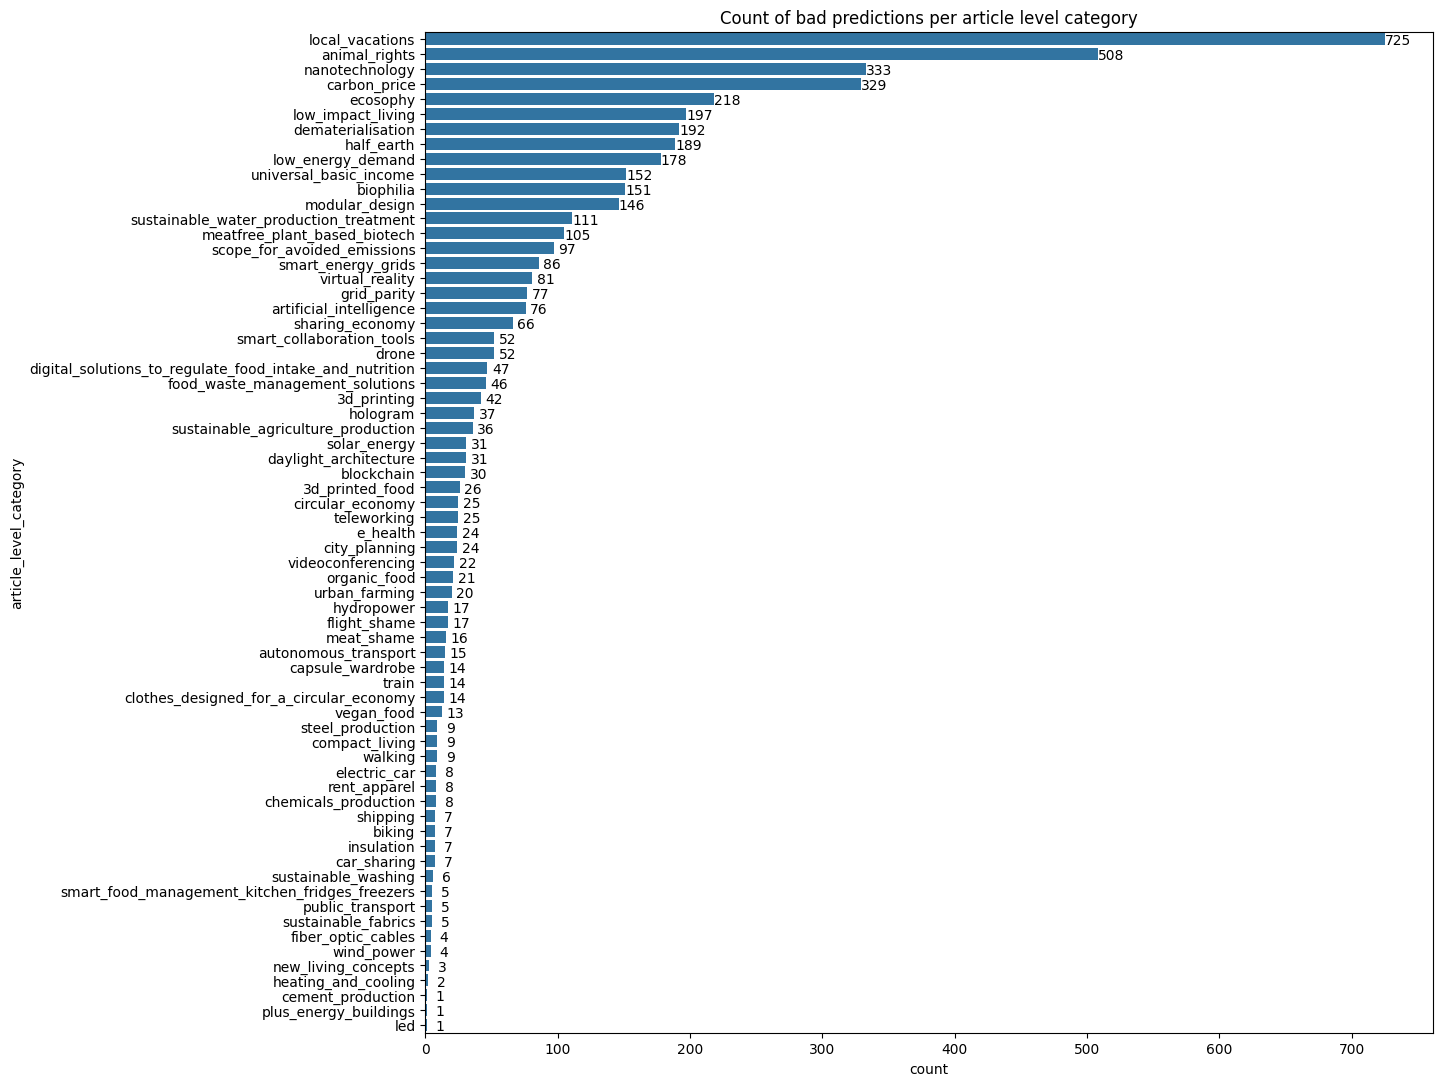

In [25]:
# get count by article level category   
count_per_article_category = bad_predictions["article_level_category"].value_counts().reset_index()
# plot count of bad predictions per article level category
plt.figure(figsize=(13, 13))
ax = sns.barplot(x="count", y="article_level_category", data=count_per_article_category)
# add numbers to the bars
for p in ax.patches:
    width = p.get_width()
    plt.annotate(f'{int(width)}', (width + 10, p.get_y() + 0.5), ha='center', va='center')
# set title
plt.title("Count of bad predictions per article level category")

In [26]:
from IPython.display import Markdown
row = predictions.iloc[1355]
print(f"----- Article {row.article_id} - Section {row.section_id}")
print(f"----- Title: {raw_data.iloc[int(row.article_id)]['title']}")
print(f"----- Final category: {row.section_category}, because: {row.reasoning}")
for annotator_id, conversation in row.explanation.items():
    print(f"\nAnnotator #{annotator_id}")
    for idx, (msg_type, msg) in enumerate(conversation.items()):
        if msg_type.startswith("prediction"):
            print(f"{'-'*(idx+1)} Chosen category: {msg['category']}")
            print(f"{'-'*(idx+1)} Reasoning: {msg['reasoning']}")
        else:
            print(f"{'-'*(idx+1)} The evaluator responded and claimed the annotation as '{msg['conclusion']}'.")
            print(f"{'-'*(idx+1)} Their reasoning: {msg['reasoning']}")

----- Article 81 - Section 16
----- Title: How to Save Bike-Sharing: An Evidence-Based Survival Toolkit for Policy-Makers and Mobility Providers
----- Final category: public_transport, because: The article segment discusses bike sharing, public acceptance, and policy-making, which are all related to public transport. The focus is on promoting mobility and policy-making to support public transportation through bike-sharing programs. The mention of bike sharing and public acceptance in the context of policy-making aligns with the category of public transport. The category of autonomous transport is not suitable as it does not specifically address the public acceptance and policy-making aspects related to bike sharing. None of the sections seem to fit under autonomous transport.

Annotator #1
- Chosen category: autonomous_transport
- Reasoning: This article section is focused on the public acceptance of bike sharing in Gothenburg, which falls under the umbrella of autonomous transport. Th

In [27]:
# drop bad predictions
predictions = predictions.loc[~predictions.section_category.isin(["none","unsure"])]
print("Final number of predictions: ", predictions.shape[0])

Final number of predictions:  39428


# Save data

In [28]:
# get old already annotated data
old_data = load_json_data("../../training/datasets")
old_data = old_data.rename(columns={"sentence_id": "section_id"})
print(old_data.shape)

(9416, 5)


In [29]:
final_dataset = []
progress_bar = tqdm(total=predictions.shape[0])
progress_bar.set_description("Processing")
count_skipped = 0
for idx, row in predictions.iterrows():
    if row["article_id (old)"] in set(old_data.article_id.values):
        # human annotation already exists, skip
        progress_bar.set_description(f"Skipped {count_skipped} samples")
        count_skipped += 1
        progress_bar.update(1)
        continue
    article_id = int(row.article_id)
    section_id = row.section_id
    label = row.section_category
    text = row.text
    spans = []
    new_row = {
        "article_id": article_id,
        "section_id": section_id,
        "label": label,
        "text": text,
        "spans": spans
    }
    final_dataset.append(new_row)
    progress_bar.update(1)
final_dataset = pd.DataFrame(final_dataset)
print(final_dataset.shape)
final_dataset.head()

Skipped 3741 samples: 100%|█████████▉| 39310/39428 [00:30<00:00, 1452.70it/s]

(35686, 5)


,article_id,section_id,label,text,spans
0,21,0,3d_printing,The Benefits of 3D Printing: Remote Production...,[]
1,21,1,3d_printing,How is it creating a new paradigm? How can it ...,[]
2,21,2,3d_printing,Read the previous episodes of our Benefits of ...,[]
3,21,3,3d_printing,"Since then, 3D printing has brought a deep and...",[]
4,21,4,3d_printing,Machines are connected thanks to the Internet ...,[]


In [30]:
final_dataset = pd.concat([old_data, final_dataset])
print("Final dataset shape: ", final_dataset.shape)
final_dataset.head()

Final dataset shape:  (45102, 5)


,text,label,spans,article_id,section_id
0,J Sol. Energy Eng. April 2018; 140(2): 021012....,fiber_optic_cables,[fiber-optic],424,8
1,Energy Eng. April 2018; 140(2): 021012. https:...,fiber_optic_cables,[fiber-optic],424,9
2,April 2018; 140(2): 021012. https://doi.org/10...,fiber_optic_cables,[fiber-optic],424,10
3,"The scope included the design, development, an...",fiber_optic_cables,[fiber-optic cables],424,11
4,The designed system is comprised of two subsys...,fiber_optic_cables,"[fiber-optic cables, fiber-optic cables]",424,12


In [31]:
# save dataset to parquet
final_dataset.to_parquet("final_dataset.parquet")